# Forecasting of Covid Data using sktime
## **F. S. Abril, N. T. Dominguez, Z. Cucunuba**

Assessing how many cases and deaths there are in a population due to an epidemic (or pandemic) and how many cases and deaths are expected in 2 or 3 weeks is an important task in informing the public health response to an epidemic. To do this, it is common to use epidemiological models that calibrate epidemiological curves by varying their parameters taking into account the data collected by a health surveillance system ([Walker P. et. al. 2020](https://www.science.org/doi/10.1126/science.abc0035)). Likewise, in the case of respiratory diseases such as COVID-19, these epidemiological models were characterized by usually being of two types: compartmental models or agent models ([Grefenstette J. et. al. 2013](http://www.ncbi.nlm.nih.gov/pubmed/24103508)).

In the case of compartmental models, the population subject to infection is divided into a small number of compartmentalized groups, each of these groups being made up of identical individuals in terms of their status with respect to the infection in question. Then, based on a deterministic or stochastic evolution equation (usually a differential equation for each compartment), each compartment in the population is evolved, leaving a set of free parameters that are fixed through the calibration process ([Watson O. 2021](https://www.ojwatson.co.uk/2021/01/04/introduction-to-squire/)). Also, it is worth mentioning that this set of parameters obeys epidemiological variables such as transmission rate, exposure time, among others.

In the case of agent models, a synthetic population is constructed that has the same statistical characteristics as the real population. For example, in the case of a city, this synthetic population can be constructed in such a way that it respects the distribution of age groups, the population density in the different neighborhoods, among others. Then, interaction rules are generated between the agents of the synthetic population in such a way that each agent or individual modifies its state according to the natural history of the disease. Thus, unlike compartmental models, agent models require multiple simulations that allow estimating the set of parameters that best fit the data of the epidemic curves observed in reality. In fact, it is normal that an agent model has greater freedom to introduce multiple non-pharmacological measures in a population than a compartmental model, for example the use of masks, reducing the number of contacts, opening educational centers, among others. However, this freedom also implies greater complexity of computational resources.

Finally, regardless of the type of modeling used, once the calibration process is completed, the model is allowed to evolve over time, leaving the parameters fixed (baseline state) or varying them to generate different projection scenarios that allow policy makers to decision to have an idea of what could happen in an epidemic outbreak.

The idea of this tutorial is to make a prediction of COVID-19 cases and deaths in June 2021 for 3 weeks in Bogotá taking open data extracted from ([Positive cases of COVID-19 in Colombia](https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia-/gt2j-8ykr/data_preview)). For this purpose, Machine Learning tools are used that allow predicting time series when the data set has a good number of data.

# Forecasting

A time series can be break down into the following components [seabold2010]:
- **Level:** The average value in the series (this defines the scale).
- **Trend (optional):** Increasing or decreasing values.
- **Seasonality (optional):** Repeating short-term cycles (we don’t have this at the epidemiological week level for COVID-19).
- **Noise (non-systematic):** The random variation in the series.

Financial or transaction data may be useful to inform trends in epidemiological time series since these would allow the identification of trend changes by specific merchant categories (food, health, transportation, etc.), and identify the correct lag between time series to apply different time series models. In the simplest case, short-term predictions and without including exogenous data, Forecasting can be implemented through the forecaster ```UnobservedComponents``` in Python ([UnobservedComponents](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)).

Nevertheless, other types of forecasters can also be used such as RandomForest, GradientBoosting, etc., with the warning that one forecaster may be better than another depending on the time of evaluation of the prediction (pandemic or endemic period).
Therefore, it is important to mention that there are different metrics to evaluate the effectiveness of a Forecasting model used in epidemiology such as the Continuous Ranked Probability Score (CRPS) or the Weighted Interval Score (WIS), as well as those used in Machine Learning such as Mean Absolute Error (MAE) or the root Mean Squared Error (MSE).

# Import libraries

First, we load the packages we will require for the analysis:

In [1]:
# Import libraries for data wrangling ----
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Import Machine Learning utilities ----
from sklearn.linear_model import LinearRegression
from sktime.forecasting.all import EnsembleForecaster
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.structural import UnobservedComponents
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)
from sktime.forecasting.all import (
    mean_absolute_percentage_error as mape,
    mean_absolute_scaled_error as mase,
    mean_squared_percentage_error as mspe,
    mean_squared_error as mse,
    ForecastingHorizon,
    NaiveForecaster
)

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 220)

The ```pandas``` package provides useful functions for manipulating data, while the ```sklearn``` package provides multiple time series prediction models using Machine Learning ([scikit-learn](https://scikit-learn.org/stable/)). In fact, ```sklearn.ensemble``` provides other types of predictors such as ```RandomForestRegressor``` and ```GradientBoostingRegressor```, although for the sake of this tutorial the ```UnobservedComponents``` predictor will be used ([UnobservedComponents](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)).

# Local functions

Below, two local functions are defined that will allow us to estimate the size of the optimal test set and the optimal period of the seasonal component $c_t$ in the Machine Learning algorithm ([UnobservedComponents](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)). An important point to mention is that the dataframe index must be in date format for the ML algorithm to work, which is why the ```get_date_index``` function is defined.

In [2]:
# Set date_index from epidemiological year and epidemiological week
def get_date_index(df_):
    year_list = df_["year"].tolist()
    week_list = df_["epi_week"].tolist()
    args_ = [(int(year_list[i]), int(week_list[i]), 1) for i in range(len(df_))]
    date_index = [pd.Timestamp.fromisocalendar(*args_[i]) for i in range(len(df_))]
    return date_index

In [3]:
# Forecasting model using UnobservedComponents
def forecasting_model(df_, vars_, freq_, periods_range, test_size_range, verbose=0):
    df_params = []
    
    for n_var_, var_ in enumerate(vars_):
        print("****************** {} - {} ******************".format(n_var_, var_))
        
        y_ = df_[var_].copy()
        y_.index = pd.PeriodIndex(pd.date_range(y_.index[0], periods = len(y_.index), freq = freq_))
        
        for test_size in test_size_range:
            y_train, y_test = temporal_train_test_split(y_, test_size = test_size)
            fh = ForecastingHorizon(y_test.index, is_relative = False)
            
            for period in periods_range:
                # Forecasters
                forecaster = UnobservedComponents(level = "local linear trend", freq_seasonal = [{"period": period}])
                forecaster.fit(y_train)
                y_pred = forecaster.predict(fh)
            
                df_metrics = pd.DataFrame(
                    {
                        "variable" : [var_],
                        "period" : [period],
                        "test_size" : [test_size],
                        "RMSE" : [np.sqrt(mse(y_test, y_pred))],
                        "MAPE" : [mape(y_test, y_pred, symmetric = False)],
                        "MASE" : [mase(y_test, y_pred, y_train = y_train)]
                    }
                )
                df_params.append(df_metrics)
                
                if verbose > 0:
                    print("Tested period: {}".format(period))
            if verbose > 0:
                print("Tested test_size: {}".format(test_size))
    
    df_params = pd.concat(df_params)
    
    return df_params

# Read data

Before running the code in this section, make sure that you have downloaded the daily COVID-19 public datasets from the selected locations. You can do so by running the ```download_covid19_data.R``` script. Now, as mentioned, the prediction will be made with data from Bogotá from June 2021.

In [9]:
df_epi_0 = pd.read_csv("../data/covid19_cases_deaths_daily.csv")
df_epi_0["date"] = pd.to_datetime(df_epi_0["date"], errors = "coerce")

# Local estimation example
region_ = "Bogota"
date_ = "2021-06-01"

df_epi = df_epi_0[((df_epi_0["city"] == region_) & (df_epi_0["date"] <= date_))][["date", "cases", "deaths"]].fillna(0)

# Set date index
df_epi.set_index(["date"], inplace = True)

# Define the period as daily data
period_ = "1D"
df_epi.head(10)

,cases,deaths
date,,
2020-02-27,1.0,0.0
2020-02-28,1.0,0.0
2020-03-01,2.0,0.0
2020-03-04,1.0,0.0
2020-03-05,4.0,0.0
2020-03-06,6.0,0.0
2020-03-07,8.0,0.0
2020-03-08,5.0,0.0
2020-03-09,7.0,0.0


# Estimate Optimal Period and Test size

In [5]:
df_params_ = forecasting_model(df_ = df_epi, vars_ = ["cases", "deaths"], freq_ = "D", periods_range = range(5, 30), test_size_range = range(5, 21))
df_params_

,variable,period,test_size,RMSE,MAPE,MASE
0,cases,5,5,905.958215,0.129621,3.548652
0,cases,6,5,815.861702,0.121508,3.346648
0,cases,7,5,745.717973,0.110405,3.067137
0,cases,8,5,804.607669,0.120501,3.324064
0,cases,9,5,842.405661,0.124958,3.444586
...,...,...,...,...,...,...
0,deaths,25,20,27.044321,0.200547,3.264677
0,deaths,26,20,23.003132,0.168905,2.741074
0,deaths,27,20,25.062159,0.185829,3.013294
0,deaths,28,20,25.799827,0.191212,3.104893


For daily cases, the optimal set of parameters is:

In [6]:
df_opt_cases = df_params_[df_params_["variable"] == "cases"]
df_opt_cases[df_opt_cases["RMSE"] == df_opt_cases["RMSE"].min()]

,variable,period,test_size,RMSE,MAPE,MASE
0,cases,7,13,598.75981,0.083574,2.49667


For daily deaths, the optimal set of parameters is:

In [7]:
df_opt_deaths = df_params_[df_params_["variable"] == "deaths"]
df_opt_deaths[df_opt_deaths["RMSE"] == df_opt_deaths["RMSE"].min()]

,variable,period,test_size,RMSE,MAPE,MASE
0,deaths,20,16,10.287834,0.066697,1.101751


# Plotting the result of the forecasting model

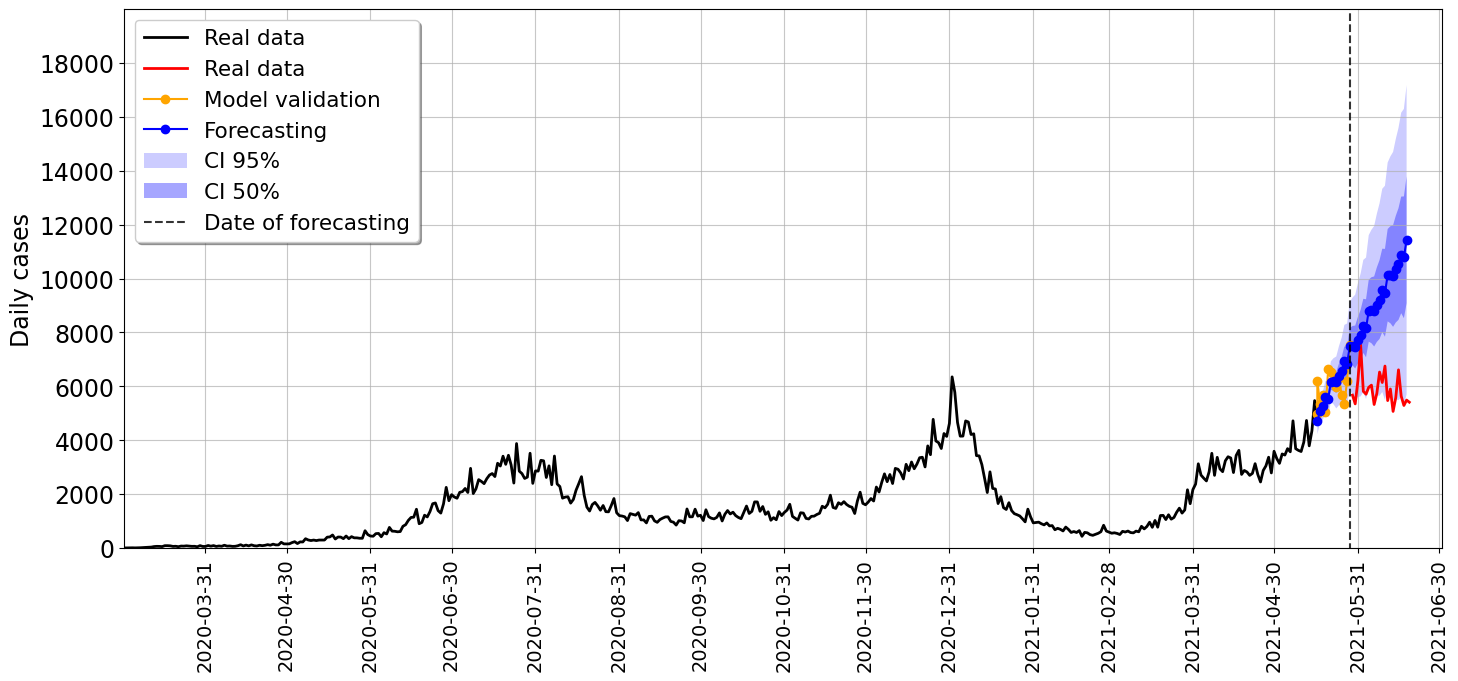

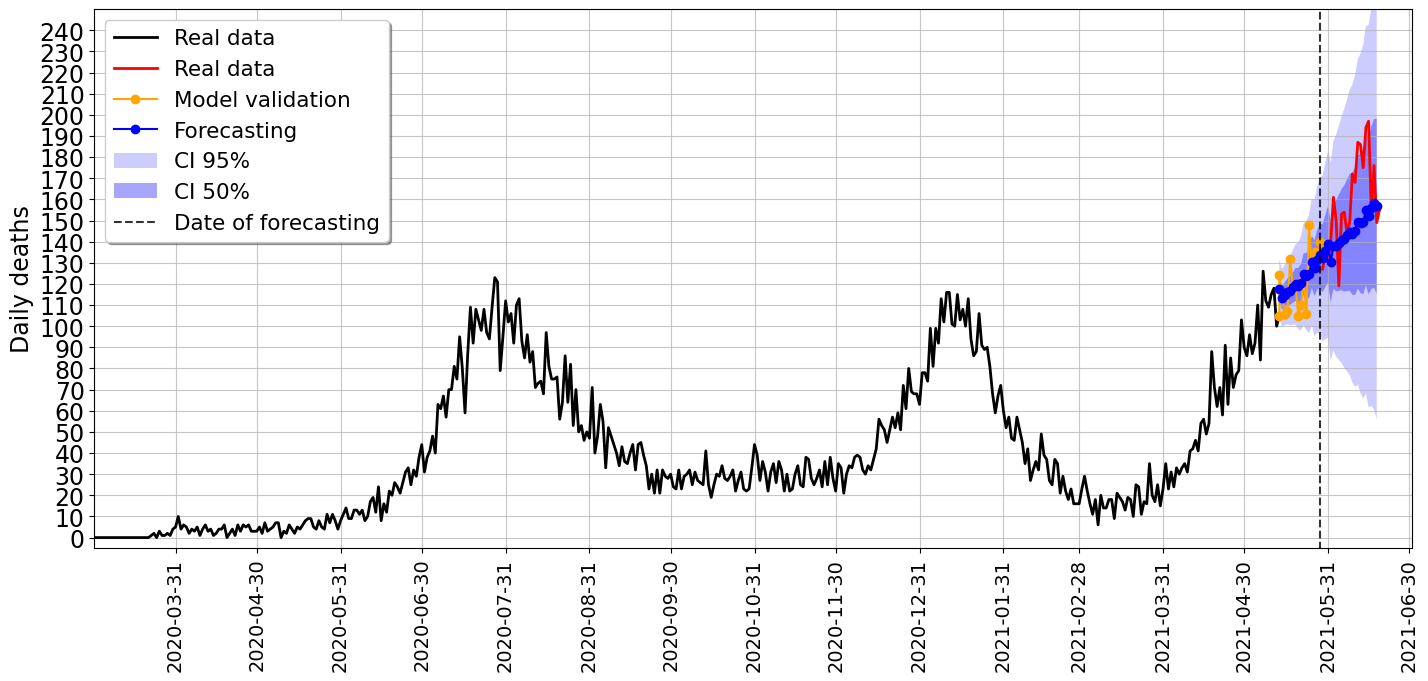

In [10]:
pred_size = 21 # Future forecasting points

vars_ = ["cases", "deaths"]
lower_percentile = 0.05
upper_percentile = 1 - lower_percentile
lower_percentile_2 = 0.25
upper_percentile_2 = 1 - lower_percentile_2
dict_periods = {"cases" : 7, "deaths" : 20}
dict_test_size = {"cases" : 13, "deaths" : 16}
dict_indicator = {"cases" : "Daily cases", "deaths" : "Daily deaths"}
freq_ = "D"

for n_values, values_ in enumerate(vars_):
    #print(f'****************** {values_} ******************')
    
    y_ = df_epi[values_].copy()
    test_size = dict_test_size[values_]
    period_col =  dict_periods[values_]
    all_days = len(y_)
    test_days = test_size
    train_days = all_days - test_days

    dates_train = pd.date_range(y_.index[0], periods = train_days, freq = freq_)
    dates_test = pd.date_range(dates_train[-1], periods = test_days, freq = freq_)
    dates_pred = pd.date_range(dates_train[-1], periods = test_days + pred_size, freq = freq_)
    
    y_.index = pd.PeriodIndex(pd.date_range(y_.index[0], periods = len(y_.index), freq = freq_))
    y_train, y_test = temporal_train_test_split(y_, test_size = test_size)
    
    proy_time_window = pd.PeriodIndex(pd.date_range(dates_train[-1], periods = test_size + pred_size, freq = freq_))
    fh = ForecastingHorizon(proy_time_window, is_relative = False)

    forecaster = UnobservedComponents(
        level = "local linear trend",
        freq_seasonal = [{"period": period_col}],
        use_exact_diffuse = True
    )
    forecaster.fit(y_train)
    
    # Projection
    y_pred = forecaster.predict(fh)
    
    # Percentiles
    quantile_pred = forecaster.predict_quantiles(fh, alpha = [lower_percentile, 0.5, upper_percentile])
    quantile_dates = quantile_pred.index.to_timestamp()
    quantile_lower = quantile_pred[values_][lower_percentile].to_numpy()
    quantile_upper = quantile_pred[values_][upper_percentile].to_numpy()
    
    quantile_pred_2 = forecaster.predict_quantiles(fh, alpha = [lower_percentile_2, 0.5, upper_percentile_2])
    quantile_dates_2 = quantile_pred_2.index.to_timestamp()
    quantile_lower_2 = quantile_pred_2[values_][lower_percentile_2].to_numpy()
    quantile_upper_2 = quantile_pred_2[values_][upper_percentile_2].to_numpy()
    
    plt.rcParams.update({"font.size": 17})
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(w = 17, h = 7)

    P = []

    # Real data
    p1 = ax1.plot(dates_train, y_train, color = "black", marker = "", linestyle = "-", linewidth = 2, label = "Real data")
    P.append((p1[0],))
    
    # Real data after maximum validation date
    date_min = y_test.index.to_timestamp().max()
    date_max = date_min + pd.DateOffset(pred_size)
    y_real = df_epi_0[((df_epi_0["city"] == region_) & (df_epi_0["date"] >= date_min) & (df_epi_0["date"] <= date_max))][["date", values_]]
    p1_ = ax1.plot(y_real["date"], y_real[values_], color = "red", marker = "", linestyle = "-", linewidth = 2, label = "Real data")
    P.append((p1_[0],))

    # Validation data
    dates_proof = np.append(np.array([dates_train[-1]]), np.array([date for date in dates_test]))
    data_proof = np.append(np.array([y_train[-1]]), np.array([y_val for y_val in y_test]))
    p2 = ax1.plot(dates_proof, data_proof, color = "orange", marker = "o", linestyle = "-", label = "Model validation")
    P.append((p2[0],))

    # Forecasting data
    color_ = "blue"
    p3 = ax1.plot(dates_pred, y_pred, color = color_, marker = "o", linestyle = "-", label = "Forecasting")
    ax1.fill_between(
        quantile_dates,
        quantile_lower,
        quantile_upper,
        where = quantile_upper >= quantile_lower,
        alpha = 0.20,
        facecolor = color_,
        interpolate = True,
        label = "CI 95%"
    )
    ax1.fill_between(
        quantile_dates_2,
        quantile_lower_2,
        quantile_upper_2,
        where = quantile_upper_2 >= quantile_lower_2,
        alpha = 0.35,
        facecolor = color_,
        interpolate = True,
        label = "CI 50%"
    )
    P.append((p3[0],))

    # Plot details
    time_labels = pd.date_range(dt.datetime(2020,1,1), periods = 40, freq = "1M")
    plt.xticks(time_labels, rotation = 90, fontsize = 14)
    ax1.set_xlim(dt.datetime(2020,3,1), dt.datetime(2021,7,1))
    ax1.set_ylabel(dict_indicator[values_])
    
    if values_ == "cases":
        ax1.yaxis.set_ticks(np.arange(0, 20000, 2000))
        ax1.set_ylim(-5, 20000)
    elif values_ == "deaths":
        ax1.yaxis.set_ticks(np.arange(0, 250, 10))
        ax1.set_ylim(-5, 250)

    ax1.grid(alpha = 0.7)
    ax1.vlines(x = dates_proof[-1], ymin = -100, ymax = 200000, colors = "black", alpha = 0.8, linestyle = "dashed", label = "Date of forecasting")
    
    # Legend
    ax1.legend(
        loc = "upper left",
        #bbox_to_anchor = (0.5, 1.11),
        fancybox = True,
        shadow = True,
        ncol = 1,
        fontsize = 15.5
    )
    
    #plt.savefig("./figure_proof_{}.png".format(values_), bbox_inches = "tight", pad_inches = 0.03, dpi = 250)